# 参考資料
**書籍**


**Kaggle**


**自分で作成したファイル**

**その他**
- 8位 xgboost_5fold.ipynb
- 18位 competition_2_nakamura_v3_提出.ipynb
- HomeCledit_data_final.ipynb
- 17位 try6_Home_Credit_Default_Risk.ipynb

## ライブラリ・データセットのインポート

In [41]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [42]:
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier # 特徴量の重要度評価で用いる

In [43]:
FILE_PATH = ''
OUTPUT_DIR = ''

train = pd.read_csv(FILE_PATH + 'train.csv')
test = pd.read_csv(FILE_PATH + 'test.csv')

df = pd.concat([train, test], axis=0)
df.reset_index(inplace=True)

In [44]:
# 結合したことでfloatになった"TARGET"をIntに変換
df["TARGET"] = df["TARGET"].astype("Int64")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head(10)

,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,675000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.010032,-9233,-878,-333.0,-522,NaN,1,1,1,1,0,0,Core staff,2.0,2,2,0,1,1,0,1,1,School,NaN,0.372591,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,1,1,0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,585000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.008019,-20148,365243,-4469.0,-3436,NaN,1,0,0,1,0,0,NaN,2.0,2,2,0,0,0,0,0,0,XNA,NaN,0.449567,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,2,2,0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,270000.0,Family,State servant,Secondary / secondary special,Married,House / apartment,0.004960,-18496,-523,-3640.0,-2050,NaN,1,1,1,1,1,0,Core staff,2.0,2,2,0,0,0,0,0,0,Postal,NaN,0.569503,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN
3,3,3,0,Cash loans,F,N,Y,0,67500.0,152820.0,8901.0,135000.0,Children,Pensioner,Lower secondary,Widow,House / apartment,0.005002,-24177,365243,-4950.0,-3951,NaN,1,0,0,1,1,0,NaN,1.0,3,3,0,0,0,0,0,0,XNA,NaN,0.105235,0.767523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,1,Cash loans,M,N,N,0,157500.0,271066.5,21546.0,234000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,With parents,0.006296,-10685,-697,-5101.0,-3226,NaN,1,1,1,1,0,0,Drivers,2.0,3,3,0,0,0,0,1,1,Business Entity Type 3,0.342344,0.202490,0.669057,0.0,0.0,0.0,0.0,-1243.0,0.0,0.0,0.0,4.0
5,5,5,1,Cash loans,F,N,Y,0,135000.0,247500.0,19971.0,247500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.018209,-16795,-425,-2796.0,-324,NaN,1,1,0,1,0,0,Cleaning staff,2.0,3,3,0,0,0,0,0,0,Transport: type 4,NaN,0.552871,NaN,0.0,0.0,0.0,0.0,-307.0,NaN,NaN,NaN,NaN
6,6,6,0,Cash loans,F,N,Y,0,189000.0,332946.0,17127.0,238500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.011657,-14519,-4089,-8110.0,-5499,NaN,1,1,0,1,0,0,Cooking staff,2.0,1,1,0,1,1,0,0,0,Trade: type 3,NaN,0.658005,0.399676,6.0,0.0,6.0,0.0,-1918.0,0.0,0.0,0.0,3.0
7,7,7,1,Cash loans,M,N,Y,0,157500.0,203760.0,24309.0,180000.0,Unaccompanied,Working,Higher education,Single / not married,House / apartment,0.006671,-8624,-379,-1793.0,-1192,NaN,1,1,0,1,0,0,NaN,1.0,2,2,0,0,0,0,0,0,Business Entity Type 3,NaN,0.287687,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
8,8,8,0,Cash loans,M,Y,N,1,324000.0,808650.0,22234.5,675000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.010643,-14614,-612,-5137.0,-4040,1.0,1,1,0,1,0,0,Managers,3.0,2,2,0,0,0,0,1,1,Military,NaN,0.707878,0.629674,1.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0
9,9,9,1,Cash loans,F,N,Y,1,180000.0,207117.0,16492.5,171000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.020713,-17604,-5443,-455.0,-916,NaN,1,1,0,1,0,0,Sales staff,3.0,3,3,0,0,0,1,1,0,Self-employed,0.509716,0.277001,NaN,1.0,0.0,1.0,0.0,-905.0,NaN,NaN,NaN,NaN


## 前処理

### 欠損値の補完

In [45]:
def missing_values(df):
    # 0日は欠損値扱いする
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True) # set null value

    return df

### 外れ値の削除

In [46]:
def outlier(df):
    # 'AMT_INCOME_TOTAL' が 20000000 以上の場合、欠損値 (NaN) に置き換える
    df.loc[df['AMT_INCOME_TOTAL'] >= 20000000, 'AMT_INCOME_TOTAL'] = np.nan
    # エラーの日数のデータは欠損値に置き換える
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

    return df

## 特徴量エンジニアリング

### 特徴量の作成

In [47]:
def create_new_features(df):
    # AMT（お金関係） に関する特徴量（Amount？）

    # クレジット額（‘AMT_CREDIT’） /
    # 定期的に支払うローン("AMT_ANNUITY") # 年金支払額を借入金で割る
    df["Credit_Annuity_Ratio"] = df["AMT_ANNUITY"] / df["AMT_CREDIT"] # 重要
    # 融資対象となる商品の価格 # 借入金をローン対象額で割る
    df["Credit_Goods_Ratio"] = df["AMT_CREDIT"] / df["AMT_GOODS_PRICE"]

    # 収入額（’AMT_INCOME_TOTAL’） /
    # 定期的に支払うローン # 年金支払額を所得で割る
    df["Income_Annuity_Ratio"] = df["AMT_INCOME_TOTAL"] / df["AMT_ANNUITY"]
    # ローン額(’AMT_CREDIT’) 借入金を所得で割る
    df["Income_Credit_Ratio"] = df["AMT_INCOME_TOTAL"] / df["AMT_CREDIT"]
    # 家族の人数と収入
    df["Income_Per_Person"] = df["AMT_INCOME_TOTAL"] / df["CNT_FAM_MEMBERS"]
    # 雇用日(’DAYS_EMPLOYED’) / # 総所得金額を就労期間で割る
    df['Income_Employed_Ratio'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    # 誕生日('DAYS_BIRTH') /
    df['Income_Birth_Ratio'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']

    df['INCOME_PER_CHILD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['INCOME_PER_FAMILY_MEMBER'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['INCOME_TO_REGISTRATION_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_REGISTRATION']
    df['INCOME_SUB_ANNUITY_PER_MONTH'] = df['AMT_INCOME_TOTAL'] / 12. - df['AMT_ANNUITY']

    # 定期的に支払うローン("AMT_ANNUITY")
    df['ANNUITY_TO_GOODS_PRICE_RATIO'] = df['AMT_ANNUITY'] / df['AMT_GOODS_PRICE']
    df['ANNUITY_TO_AGE_RATIO'] = df['AMT_ANNUITY'] / df['DAYS_BIRTH']
    df['ANNUITY_TO_EMPLOYED_RATIO'] = df['AMT_ANNUITY'] / df['DAYS_EMPLOYED']
    df['ANNUITY_TO_REGISTRATION_RATIO'] = df['AMT_ANNUITY'] / df['DAYS_REGISTRATION']
    df['ANNUITY_TO_ID_PUBLISH_RATIO'] = df['AMT_ANNUITY'] / df['DAYS_ID_PUBLISH']

    # ローン額(’AMT_CREDIT’)
    df['CREDIT_PER_FAMILY_MEMBER'] = df['AMT_CREDIT'] / df['CNT_FAM_MEMBERS']
    df['CREDIT_PER_CHILD'] = df['AMT_CREDIT'] / (1 + df['CNT_CHILDREN'])
    df['CREDIT_TO_GOODS_PRICE_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['CREDIT_TO_AGE_RATIO'] = df['AMT_CREDIT'] / df['DAYS_BIRTH']

    # 申請の1時間前にクライエントに問い合わせた回数('AMT_REQ_CREDIT_BUREAU_HOUR')
    df['ENQUIRY_CREDIT_BUREAU_HOUR_TO_DAY'] = df['AMT_REQ_CREDIT_BUREAU_HOUR'] * 24
    df['ENQUIRY_CREDIT_BUREAU_MONTH_TO_QUARTER_RATIO'] = df['AMT_REQ_CREDIT_BUREAU_MON'] / df['AMT_REQ_CREDIT_BUREAU_QRT']

    # ローンが与えられる商品の価格
    df['GOODS_PRICE_TO_AGE_RATIO'] = df['AMT_GOODS_PRICE'] / df['DAYS_BIRTH']
    df['GOODS_PRICE_TO_EMPLOYED_RATIO'] = df['AMT_GOODS_PRICE'] / df['DAYS_EMPLOYED']
    df['GOODS_PRICE_TO_INCOME_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_INCOME_TOTAL']
    # ローン対象金額から借入金を引く
    df["DOWNPAYMENT"] = df["AMT_GOODS_PRICE"] - df["AMT_CREDIT"]

    # 日付に関する特徴量

    # 年齢
    # 申し込み時点の年齢
    df["Age"] = -df["DAYS_BIRTH"] / 365

    # 雇用日(’DAYS_EMPLOYED’) /
    # 誕生日 # 就労期間を年齢で割る
    df['Days_Employed_Birth_Ratio'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['EMPLOYED_SUB_AGE'] = df['DAYS_EMPLOYED'] - df['DAYS_BIRTH']
    # 車の所持年数（’OWN_CAR_AGE’）
    df['Car_Employed_Ratio'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['DAYS_BIRTH_365_OWN_CAR_AGE']= (df['DAYS_BIRTH']/ 365)- df['OWN_CAR_AGE']

    # 誕生日('DAYS_BIRTH') /
    # ID変更日('DAYS_ID_PUBLISH')
    df['Id_Birth_Ratio'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    # 車の所持年数（’OWN_CAR_AGE’）
    df['Car_Birth_Ratio'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    # 電話の変更日('DAYS_LAST_PHONE_CHANGE')
    df['Phone_Birth_Ratio'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

    # ‘Ext_Source_*’（外部データ）に関する特徴量
    # 外部データの最小値、最大値、平均、中央値、分散を計算し、新たな特徴量を作成
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_Sources_{}'.format(function_name.upper())
        df[feature_name] = eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)


    return df

### カテゴリ変数のエンコーディング

- LabelEncoding

In [48]:
def label_encoder(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    for column in categorical_columns:
        df[column] = df[column].fillna('').astype('str') # 欠損値の補完をする
        label_encoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column])

    return df

### 特徴量の選択

#### 特徴量の重要度評価

In [49]:
def feature_importance_evaluation(df):
    # データを対数変換する

    # 訓練データをX(説明変数)とy（目的変数）に分割する
    X = df.select_dtypes(include=['float', 'int'])
    X = X.drop(['TARGET'], axis=1) # 目的変数を指定する
    y = df['TARGET'] # 目的変数を指定する

    for column in X.columns.tolist():
        X[column] = X[column].apply(lambda x: np.log(x + 1))

    # 特徴量の重要度評価
    lgb = LGBMClassifier(
        random_state=42,
    )

    lgb.fit(X, y)
    importance = lgb.feature_importances_

    feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
        .sort_values(ascending=True, by='importance')

    return feature_importance

#### 特徴量の削除

In [50]:
def drop_columns(df):
    drop_list = [
        # 重要度 0
        'REG_REGION_NOT_WORK_REGION', 'DAYS_LAST_PHONE_CHANGE', 'ANNUITY_TO_ID_PUBLISH_RATIO', 
        'REG_REGION_NOT_LIVE_REGION', 'REGION_RATING_CLIENT', 'ENQUIRY_CREDIT_BUREAU_HOUR_TO_DAY',
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'CREDIT_TO_AGE_RATIO', 'DAYS_ID_PUBLISH', 'GOODS_PRICE_TO_AGE_RATIO',
        'DAYS_EMPLOYED', 'DAYS_BIRTH', 'DOWNPAYMENT', 'GOODS_PRICE_TO_EMPLOYED_RATIO', 'Income_Birth_Ratio',
        'INCOME_PER_FAMILY_MEMBER', 'DAYS_BIRTH_365_OWN_CAR_AGE', 'INCOME_TO_REGISTRATION_RATIO', 'CREDIT_TO_GOODS_PRICE_RATIO',
        'ANNUITY_TO_EMPLOYED_RATIO', 'SK_ID_CURR', 'Income_Employed_Ratio',
        # 重要度 1~8
        'FLAG_EMAIL', 'REG_CITY_NOT_WORK_CITY', 'FLAG_CONT_MOBILE', 'LIVE_REGION_NOT_WORK_REGION', 'FLAG_OWN_CAR', # 1
        'LIVE_CITY_NOT_WORK_CITY', 'DAYS_REGISTRATION', # 2
        'AMT_REQ_CREDIT_BUREAU_HOUR', 'FLAG_PHONE', 'CNT_FAM_MEMBERS', # 3
        'AMT_REQ_CREDIT_BUREAU_MON', 'CNT_CHILDREN', # 4
        'FLAG_OWN_REALTY', # 5
        'NAME_TYPE_SUITE', # 6
        'NAME_HOUSING_TYPE', # 8
    ]
    dropped_df = df.drop(columns=drop_list)

    return dropped_df

### データセットの更新

In [51]:
# 前処理
df = missing_values(df)
df = outlier(df)

# 特徴量エンジニアリング
df = create_new_features(df)
df = drop_columns(df)
df = label_encoder(df)

In [52]:
train = df[df.loc[:, 'SK_ID_CURR'] < 171202]
test = df[df.loc[:, 'SK_ID_CURR'] > 171201]

train_x = train.drop(columns=['TARGET', 'SK_ID_CURR'])
train_y = train['TARGET']
test_x = test.drop(columns=['TARGET', 'SK_ID_CURR'])

X = train_x.values
y = train_y.values
y = y.astype(int)

df.head()

,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Credit_Annuity_Ratio,Credit_Goods_Ratio,Income_Annuity_Ratio,Income_Credit_Ratio,Income_Per_Person,Income_Employed_Ratio,Income_Birth_Ratio,INCOME_PER_CHILD,INCOME_PER_FAMILY_MEMBER,INCOME_TO_REGISTRATION_RATIO,INCOME_SUB_ANNUITY_PER_MONTH,ANNUITY_TO_GOODS_PRICE_RATIO,ANNUITY_TO_AGE_RATIO,ANNUITY_TO_EMPLOYED_RATIO,ANNUITY_TO_REGISTRATION_RATIO,ANNUITY_TO_ID_PUBLISH_RATIO,CREDIT_PER_FAMILY_MEMBER,CREDIT_PER_CHILD,CREDIT_TO_GOODS_PRICE_RATIO,CREDIT_TO_AGE_RATIO,ENQUIRY_CREDIT_BUREAU_HOUR_TO_DAY,ENQUIRY_CREDIT_BUREAU_MONTH_TO_QUARTER_RATIO,GOODS_PRICE_TO_AGE_RATIO,GOODS_PRICE_TO_EMPLOYED_RATIO,GOODS_PRICE_TO_INCOME_RATIO,DOWNPAYMENT,Age,Days_Employed_Birth_Ratio,EMPLOYED_SUB_AGE,Car_Employed_Ratio,DAYS_BIRTH_365_OWN_CAR_AGE,Id_Birth_Ratio,Car_Birth_Ratio,Phone_Birth_Ratio,EXT_Sources_MIN,EXT_Sources_MAX,EXT_Sources_MEAN,EXT_Sources_NANMEDIAN,EXT_Sources_VAR
0,0,0,0,0,0,1,1,0,112500.0,755190.0,36328.5,675000.0,7,7,1,1,1,0.010032,-9233,-878.0,-333.0,-522,NaN,1,1,1,1,0,0,4,2.0,2,2,0,1,1,0,1,1,39,NaN,0.372591,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN,0.048105,1.118800,3.096742,0.148969,56250.0,-128.132118,-12.184555,112500.0,56250.0,-337.837838,-26953.5,0.053820,-3.934637,-41.376424,-109.094595,-69.594828,377595.00,755190.0,1.118800,-81.792483,NaN,NaN,-73.107332,-768.792711,6.000000,-80190.0,25.295890,0.095094,8355.0,NaN,NaN,0.056536,NaN,0.031626,0.372591,0.372591,0.372591,0.372591,0.000000
1,1,1,0,0,0,1,2,0,225000.0,585000.0,16893.0,585000.0,7,3,4,1,1,0.008019,-20148,NaN,-4469.0,-3436,NaN,1,0,0,1,0,0,0,2.0,2,2,0,0,0,0,0,0,57,NaN,0.449567,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0,0.028877,1.000000,13.319126,0.384615,112500.0,NaN,-11.167362,225000.0,112500.0,-50.346834,1857.0,0.028877,-0.838446,NaN,-3.780040,-4.916473,292500.00,585000.0,1.000000,-29.035140,0.0,NaN,-29.035140,NaN,2.600000,0.0,55.200000,NaN,NaN,NaN,NaN,0.170538,NaN,0.030623,0.449567,0.553165,0.501366,0.501366,0.002683
2,2,2,0,0,0,1,2,0,54000.0,334152.0,18256.5,270000.0,2,4,4,1,1,0.004960,-18496,-523.0,-3640.0,-2050,NaN,1,1,1,1,1,0,4,2.0,2,2,0,0,0,0,0,0,35,NaN,0.569503,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN,0.054635,1.237600,2.957851,0.161603,27000.0,-103.250478,-2.919550,54000.0,27000.0,-14.835165,-13756.5,0.067617,-0.987051,-34.907266,-5.015522,-8.905610,167076.00,334152.0,1.237600,-18.066176,NaN,NaN,-14.597751,-516.252390,5.000000,-64152.0,50.673973,0.028276,17973.0,NaN,NaN,0.110835,NaN,0.029304,0.569503,0.569503,0.569503,0.569503,0.000000
3,3,3,0,0,0,1,2,0,67500.0,152820.0,8901.0,135000.0,1,3,3,5,1,0.005002,-24177,NaN,-4950.0,-3951,NaN,1,0,0,1,1,0,0,1.0,3,3,0,0,0,0,0,0,57,NaN,0.105235,0.767523,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.058245,1.132000,7.583418,0.441696,67500.0,NaN,-2.791910,67500.0,67500.0,-13.636364,-3276.0,0.065933,-0.368160,NaN,-1.798182,-2.252847,152820.00,152820.0,1.132000,-6.320883,0.0,NaN,-5.583819,NaN,2.000000,-17820.0,66.238356,NaN,NaN,NaN,NaN,0.163420,NaN,NaN,0.105235,0.767523,0.436379,0.436379,0.109657
4,4,4,1,0,1,1,1,0,157500.0,271066.5,21546.0,234000.0,7,1,4,1,5,0.006296,-10685,-697.0,-5101.0,-3226,NaN,1,1,1

In [53]:
# 特徴量の重要度評価
feature_importance = feature_importance_evaluation(train)
feature_importance

[LightGBM] [Info] Number of positive: 13821, number of negative: 157381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9729
[LightGBM] [Info] Number of data points in the train set: 171202, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432480
[LightGBM] [Info] Start training from score -2.432480


,importance
REG_REGION_NOT_WORK_REGION,0
DAYS_LAST_PHONE_CHANGE,0
ANNUITY_TO_ID_PUBLISH_RATIO,0
REG_REGION_NOT_LIVE_REGION,0
REGION_RATING_CLIENT,0
ENQUIRY_CREDIT_BUREAU_HOUR_TO_DAY,0
FLAG_EMP_PHONE,0
FLAG_MOBIL,0
CREDIT_TO_AGE_RATIO,0
DAYS_ID_PUBLISH,0


<Axes: >

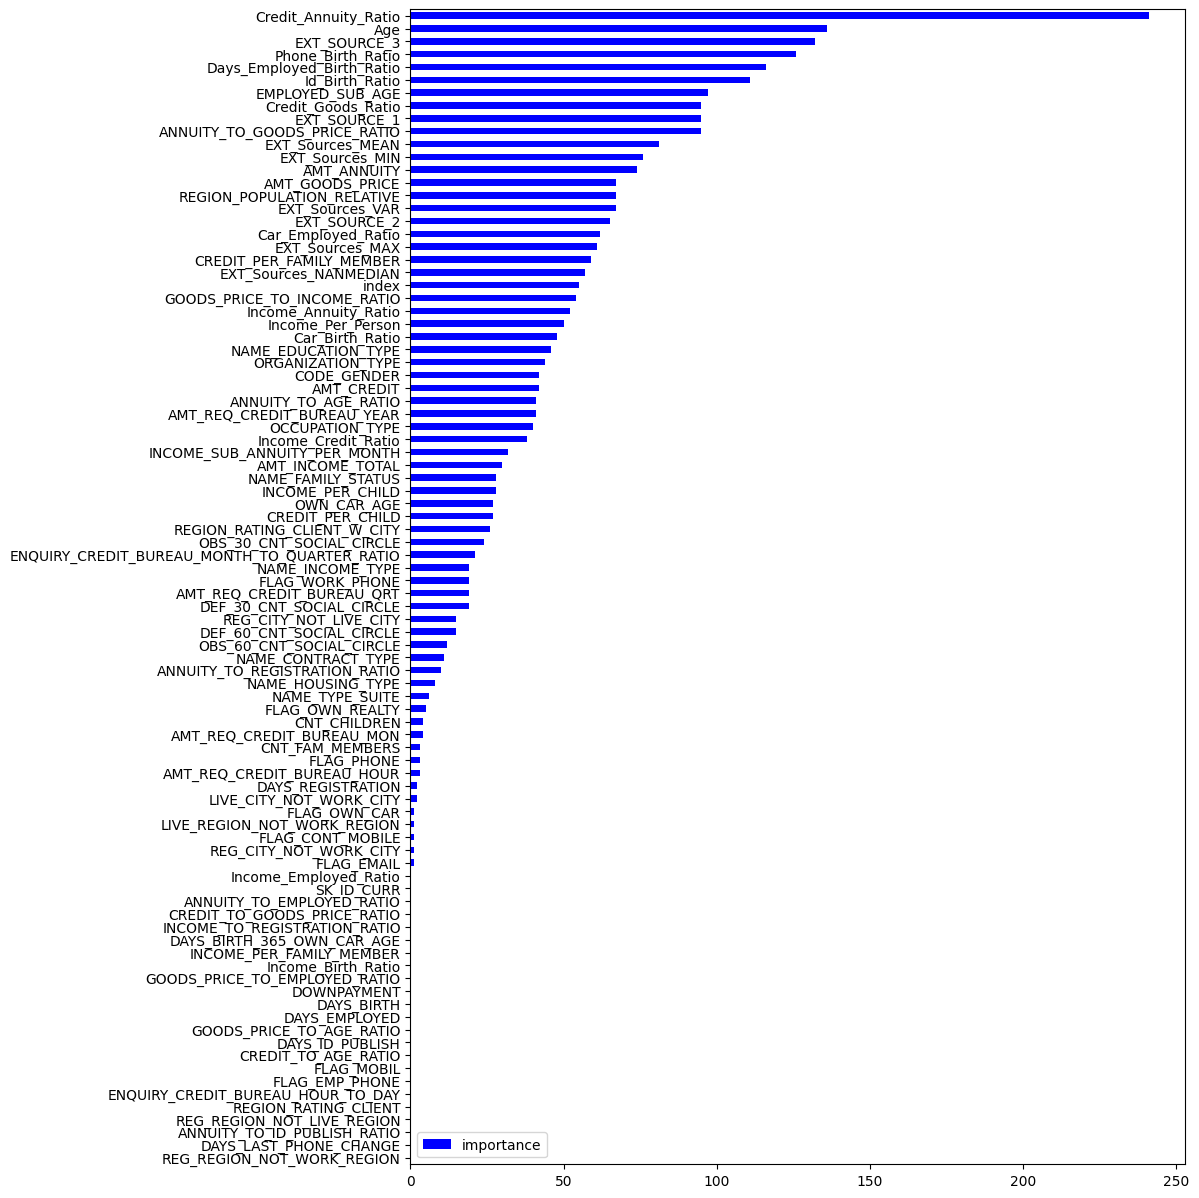

In [54]:
feature_importance.plot(kind='barh', figsize=(10, 15), color='b')

In [55]:
# ID削除
df.drop("SK_ID_CURR", axis=1, inplace=True)

In [56]:
# 初期の方でカラム名でエラー出たので（名残）
# 文字列の特殊文字を削除
df.columns = df.columns.str.replace('[^\w\s]', '').str.replace(':', '')
# 列名の空白をアンダースコアに置き換え
df.columns = df.columns.str.replace(' ', '_')

In [57]:
df.to_csv(OUTPUT_DIR + 'data.csv', index=False)

In [60]:
def file_to_xy(filename):
    data = pd.read_csv(filename, index_col=0)
    print(f'読み込み完了 {filename}')
    train = data[:171198].reset_index(drop=True)
    test = data[171198:].reset_index(drop=True).drop('TARGET', axis=1)
    # 目的変数と説明変数に分割
    X = train.drop('TARGET', axis=1)
    y = train['TARGET'].values
    return data,test,train,X,y

In [61]:
filename = 'data.csv'
data,test,train,X,y = file_to_xy(filename)

読み込み完了 data.csv
